In [1]:
"""Functions for fetching video frames, meta data and file locations"""
import sys
import re
from datetime import timedelta
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt
from iblutil.util import Bunch
from one.api import ONE
from one import params
from ibllib.io.video import *
from ScanImageTiffReader import ScanImageTiffReader
from ibllib.io.extractors.widefield import *
import json
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from matplotlib.animation import FuncAnimation
import matplotlib
matplotlib.rcParams['animation.ffmpeg_path'] = r'C:\ffmpeg\bin\ffmpeg.exe'

c:\Users\dirk\anaconda3\envs\iblenv\lib\site-packages\ibllib\io\raw_data_loaders.py:19: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import parse_version


In [2]:
video_path = r'Z:\TM_Lab\Edward\Data\iblrig_data\Subjects\M3_8m\2023-12-12\002\raw_video_data\_iblrig_leftCamera.raw.avi'

load Ca img for frame sync

In [3]:
img_path = r'Z:\TM_Lab\Edward\Cerebellum_Imaging\M_R3\20231212\acq1_20231212_2roi_behav_15hz.tif'
reader=ScanImageTiffReader(img_path)

In [4]:
def parse_text_to_dict(text):
    # Split the text into lines and initialize an empty dictionary
    lines = text.split('\n')
    config_dict = {}
    json_str = ''
    json_started = False

    # Process each line
    for line in lines:
        # Handle JSON-like structures
        if line.strip().startswith('{'):
            json_started = True

        if json_started:
            json_str += line + '\n'
            if line.strip().endswith('}'):
                try:
                    json_dict = json.loads(json_str)
                    config_dict.update(json_dict)
                    json_started = False
                    json_str = ''
                except json.JSONDecodeError:
                    pass  # Continue accumulating lines for JSON
            continue

        # Process as key-value pairs
        if '=' in line:
            key, value = line.split('=', 1)
            key = key.strip()
            value = value.strip().strip("'")

            # Convert boolean and numeric values from string
            if value.lower() == 'true':
                value = True
            elif value.lower() == 'false':
                value = False
            elif value.replace('.', '', 1).isdigit():
                value = float(value) if '.' in value else int(value)

            config_dict[key] = value

    return config_dict

def rgb_to_grayscale(rgb_image):
    return np.dot(rgb_image[..., :3], [0.2989, 0.5870, 0.1140])

In [7]:
img_meta = parse_text_to_dict(reader.metadata())
img_meta

{'SI.LINE_FORMAT_VERSION': 1,
 'SI.PREMIUM': True,
 'SI.TIFF_FORMAT_VERSION': 4,
 'SI.VERSION_COMMIT': 'cc94dee94668fb173dad594d23947a2acd45ba8f',
 'SI.VERSION_MAJOR': 2022,
 'SI.VERSION_MINOR': 0,
 'SI.VERSION_UPDATE': 1,
 'SI.acqState': 'grab',
 'SI.acqsPerLoop': 1,
 'SI.errorMsg': '',
 'SI.extTrigEnable': 1,
 'SI.fieldCurvatureRxs': '[]',
 'SI.fieldCurvatureRys': '[]',
 'SI.fieldCurvatureTilt': 0,
 'SI.fieldCurvatureTip': 0,
 'SI.fieldCurvatureZs': '[]',
 'SI.hBeams.enablePowerBox': False,
 'SI.hBeams.errorMsg': '',
 'SI.hBeams.flybackBlanking': True,
 'SI.hBeams.interlaceDecimation': '[1 1]',
 'SI.hBeams.interlaceOffset': '[0 0]',
 'SI.hBeams.lengthConstants': '[Inf Inf]',
 'SI.hBeams.name': 'SI Beams',
 'SI.hBeams.powerBoxEndFrame': 'Inf',
 'SI.hBeams.powerBoxStartFrame': 1,
 'SI.hBeams.powerFractionLimits': '[1 1]',
 'SI.hBeams.powerFractions': '[0.8 0.5]',
 'SI.hBeams.powers': '[80 50]',
 'SI.hBeams.pzAdjust': '[scanimage.types.BeamAdjustTypes.None scanimage.types.BeamAdjustType

In [10]:
img_frame_rate = img_meta['SI.hRoiManager.scanFrameRate']
img_frame_num = reader.shape()[0]

In [11]:
img_frame_num

10000

load video meta

In [9]:
meta = get_video_meta(video_path, one=None)
print(meta)

{'length': 40731, 'fps': 60, 'width': 1280, 'height': 1024, 'duration': datetime.timedelta(seconds=678, microseconds=850000), 'size': 2123790896}


load video as np array

In [91]:
duration = 120.0 # duration to load in seconds
video_frame_num = int(meta['fps']*duration)
print(video_frame_num)
video = get_video_frames_preload(video_path, frame_numbers=range(video_frame_num), mask=np.s_[:, :, :], as_list=False,
                             func=rgb_to_grayscale, quiet=False)

7200


In [14]:
print(video.shape)

(7200, 1024, 1280)


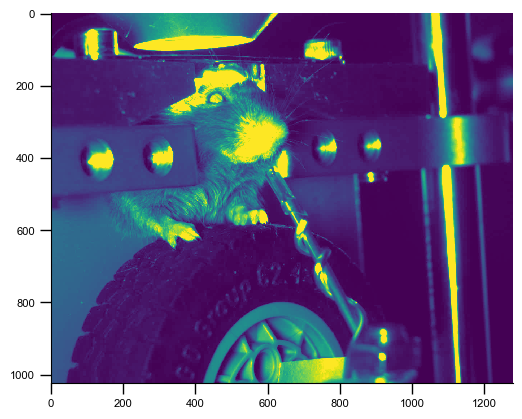

In [15]:
plt.imshow(video[0,:,:])

In [16]:
ca_img = reader.data()

In [10]:
import scipy.signal

def calculate_dff_with_moving_median(ca_imaging_data, frame_rate):
    # ca_imaging_data is a 3D NumPy array with shape (frames, height, width)
    # frame_rate is the number of frames per second

    window_size = int(20 * frame_rate)  # 20 seconds window
    frames, height, width = ca_imaging_data.shape
    dff = np.zeros_like(ca_imaging_data)

    # Calculate median baseline for the first and last 20 seconds
    first_20s_median = np.median(ca_imaging_data[:window_size, :, :], axis=0)
    last_20s_median = np.median(ca_imaging_data[-window_size:, :, :], axis=0)

    # Apply median filter to the entire dataset
    # Flatten the height and width dimensions temporarily for the filter
    reshaped_data = ca_imaging_data.reshape(frames, -1)
    median_filtered = scipy.signal.medfilt(reshaped_data, kernel_size=[window_size, 1])
    median_filtered = median_filtered.reshape(frames, height, width)

    for frame in range(frames):
        sys.stdout.write(f'\rloading frame {frame}/{frames}')
        sys.stdout.flush()
        if frame < window_size:
            baseline = first_20s_median
        elif frame >= frames - window_size:
            baseline = last_20s_median
        else:
            baseline = median_filtered[frame, :, :]
        
        # Avoid division by zero
        baseline[baseline == 0] = 1

        # Calculate ΔF/F
        dff[frame, :, :] = (ca_imaging_data[frame, :, :] - baseline) / baseline
    
    sys.stdout.write('\x1b[2K\r')  # Erase current line in stdout
    return dff


In [17]:
def calculate_dff_with_whole_median(ca_imaging_data):
    # ca_imaging_data is a 3D NumPy array with shape (frames, height, width)
    # frame_rate is the number of frames per second

    baseline = np.median(ca_imaging_data, axis=0)
    dff = (ca_imaging_data - baseline) / baseline
   
    return dff

In [19]:
ca_img.shape

(10000, 1040, 512)

In [26]:
dff = calculate_dff_with_whole_median(ca_img[:int(img_frame_rate*duration),:,:])

C:\Users\dirk\AppData\Local\Temp\ipykernel_26216\589580476.py:6: RuntimeWarning: divide by zero encountered in divide
  dff = (ca_imaging_data - baseline) / baseline
C:\Users\dirk\AppData\Local\Temp\ipykernel_26216\589580476.py:6: RuntimeWarning: invalid value encountered in divide
  dff = (ca_imaging_data - baseline) / baseline


In [68]:
def interpolate_frames(video, target_frames):
    """
    Downsample a video to a specific number of frames using linear interpolation.
    
    Parameters:
    - video: Input video as a NumPy array with shape [frames, height, width, channels].
    - target_frames: The desired number of frames in the output video.
    
    Returns:
    - Interpolated video as a NumPy array.
    """
    original_frames, height, width = video.shape
    # Generate an array of indices for the target frame count
    target_indices = np.linspace(0, original_frames - 1, num=target_frames, endpoint=True)
    
    # Initialize the interpolated video
    interpolated_video = np.zeros((target_frames, height, width), dtype=video.dtype)
    
    for i, idx in enumerate(target_indices):
        # Find the two nearest frames in the original video
        lower_idx = int(np.floor(idx))
        upper_idx = int(np.ceil(idx))
        lower_weight = upper_idx - idx
        upper_weight = idx - lower_idx
        
        if lower_idx == upper_idx:  # Directly copy the frame if indices are the same
            interpolated_video[i] = video[lower_idx]
        else:
            # Linearly interpolate between the two nearest frames
            interpolated_video[i] = lower_weight * video[lower_idx] + upper_weight * video[upper_idx]
    
    return interpolated_video

In [86]:
interp_video = interpolate_frames(video, int(duration*img_frame_rate))

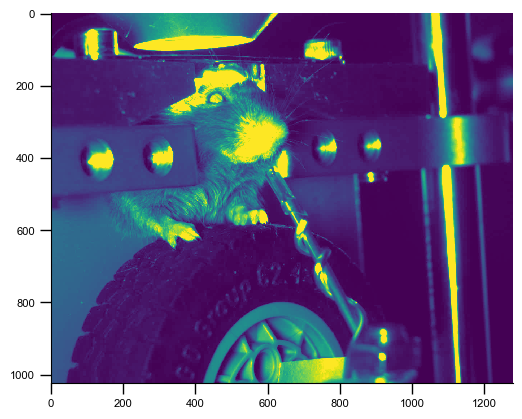

In [89]:
plt.imshow(interp_video[0])

In [95]:
def create_synchronized_video(array1, array2, duration, output_filename):
    """
    Create a video with two synchronized subplots from two numpy arrays.
    
    Parameters:
    - array1: NumPy array with shape (frames1, width, height)
    - array2: NumPy array with shape (frames2, width, height)
    - duration: in seconds
    - output_filename: String, name of the output video file
    """
    # Determine the number of frames and frame size
    frames1, width1, height1 = array1.shape
    frames2, width2, height2 = array2.shape
    
    # Calculate the duration of the videos (assuming same duration for both)
    #duration = max(frames1, frames2)
    fps = frames1/duration  # Use the lower fps for synchronization

    fig, axes = plt.subplots(1, 2)  # 1 row, 2 columns for two videos

    # Display initial frame of each video
    im1 = axes[0].imshow(array1[0,:,:], cmap = 'gray', interpolation='none')
    im2 = axes[1].imshow(array2[0,:,:], cmap = 'gray', interpolation='none')
    axes[0].xaxis.set_tick_params(labelbottom=False)
    axes[0].yaxis.set_tick_params(labelleft=False)

    # Hide X and Y axes tick marks
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[1].xaxis.set_tick_params(labelbottom=False)
    axes[1].yaxis.set_tick_params(labelleft=False)

    # Hide X and Y axes tick marks
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    def init():
        """Initializes the animation with the first frame of each video."""
        im1.set_data(array1[0,:,:])
        im2.set_data(array2[0,:,:])
        return [im1, im2]

    def animate(i):
        """Updates the content of the axes for frame i."""
        im1.set_data(array1[i,:,:])
        im2.set_data(array2[i,:,:])
        return [im1, im2]

    # Create animation
    anim = FuncAnimation(fig, animate, init_func=init, frames=frames1, interval=20, blit=True)

    # To display the animation in a Jupyter notebook
    # from IPython.display import HTML
    # HTML(anim.to_html5_video())

    # To save the animation as an MP4 file
    #anim.save(output_filename, fps=fps)
    return anim

   

def downsample_image_by_averaging(image, downsample_factor):
    """
    Downsample an image by averaging over pixel blocks.

    Parameters:
    - image: a 2D (grayscale) or 3D (color) NumPy array representing the image.
    - downsample_factor: a tuple (factor_height, factor_width) defining the
      downsampling factor for the height and width dimensions, respectively.

    Returns:
    - downsampled_image: the downsampled image as a NumPy array.
    """
    # Check if the image is grayscale or color
    if image.ndim == 3:
        height, width, channels = image.shape
    else:
        height, width = image.shape
        channels = 1
        image = image[:, :, np.newaxis]

    # Calculate the size of the downsampled image
    new_height = height // downsample_factor[0]
    new_width = width // downsample_factor[1]

    # Initialize the downsampled image
    downsampled_image = np.zeros((new_height, new_width, channels))

    for c in range(channels):
        for i in range(new_height):
            for j in range(new_width):
                # Calculate the average of each block and assign it to the downsampled image
                block = image[i*downsample_factor[0]:(i+1)*downsample_factor[0],
                              j*downsample_factor[1]:(j+1)*downsample_factor[1], c]
                downsampled_image[i, j, c] = block.mean()

    if channels == 1:
        downsampled_image = downsampled_image.reshape((new_height, new_width))

    return downsampled_image

In [41]:
downsample_factor = (2,2)
ds_img = downsample_image_by_averaging(dff[2,:,:], downsample_factor)

In [109]:
ds_ca_img = np.zeros((int(duration*img_frame_rate), ca_img.shape[1]//downsample_factor[0], ca_img.shape[2]//downsample_factor[1]))
for i in range(int(duration*img_frame_rate)):
    ds_ca_img[i,:,:] = downsample_image_by_averaging(ca_img[i,:,:], downsample_factor)

In [112]:
print(interp_video.shape)
print(ca_img.shape)

(1782, 1024, 1280)
(10000, 1040, 512)


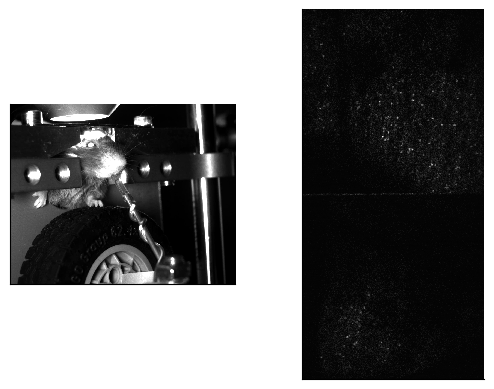

In [113]:
output_filename = r'Z:\TM_Lab\Edward\Data\iblrig_data\Subjects\M3_8m\2023-12-12\sync_data.gif'
anim = create_synchronized_video(interp_video[500:1000], ds_ca_img[500:1000], duration, output_filename)

In [115]:
writer = PillowWriter(fps=interp_video.shape[0]/duration)
anim.save("500_1000_vid.gif", writer=writer)